# Import Packages and Alter Some Settings

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from math import sqrt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import and Preprocessing

##### Import raw file

In [2]:
# replace df_base with df
df_base = pd.read_csv(r'C:\Users\sasamsel\Box\Sentiment and Stock Indexes\FinalWithMissingDays\FinalfilemissingvaluesV1.csv')

##### Preprocessing

In [3]:
# remove
df = df_base.copy()

# Drop columns not pertinent to the analysis
df.drop(['place', 'user_location', 'keyword_used', 'id', 'user_ID'], axis = 1, inplace = True)
# Replace ordinal sentiment categories with numbers for utilization in the analysis
    # very negative = 1, negative = 2, neutral = 3, positive = 4, very positive = 5
df.replace({'very negative': 1, 'negative': 2, 'neutral': 3, 'positive': 4, 'very positive': 5}, inplace = True)
# Encode emotional category to categorical to prepare for dummy variables
df['emotion_category'] = df['emotion_category'].astype('category')
# Encode date as categorical to prepare for grouping
df['Date'] = df['Date'].astype('category')
# Get dummy variables for emotion category for utilization in the analysis
df = pd.get_dummies(df, prefix = ['emotion_category'], prefix_sep = '_', columns = ['emotion_category'])
# Group the 55,000,000 tweets by date
    # For the predictor variables the average value is used. It is used instead of the sum because
    # the number of tweets each day is not uniform
    # For the dependent variables all the values are the same within a given day. Average, median,
    # min, max, and mode would all return the same value. Max was chosen as it is fastest
df = df.groupby(by = ['Date']
                ,as_index = False).agg({'valence_intensity': 'mean', 'anger_intensity': 'mean'
                                        ,'anger_intensity': 'mean', 'fear_intensity': 'mean'
                                        ,'sadness_intensity': 'mean', 'joy_intensity': 'mean'
                                        ,'sentiment_category': 'mean'
                                        ,'emotion_category_anger': 'mean', 'emotion_category_fear': 'mean'
                                        ,'emotion_category_joy': 'mean', 'emotion_category_no specific emotion': 'mean'
                                        ,'emotion_category_sadness': 'mean', 'S&P500(GSPC)Adj Close': 'max'
                                        ,'DJIA': 'max', 'Unemployment Rate, SA (%)': 'max'})

# Reset the index after grouping
df = df.reset_index()
# Drop the old index
df.drop(['index'], axis = 1, inplace = True)

# Transform the date variable (format 'MonthAbv DD') into a traditional date format ('MM/DD/YYYY')
    # Start by splitting the date into MonthAbv and DD where there is a space
df[['Month', 'Day']] = df['Date'].str.split(' ', -1, expand = True)
    # Create a dictonary to map the MonthAbv to MM
num_month = dict({'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'})
month_num = dict((v, k) for k, v in num_month.items())
    # Replace MonthABV with the appropriate MM
df['Month'].replace(month_num, inplace = True)
    # Create a year variable (All tweets are from 2020)
df['Year'] = '2020'
    # Drop the original date variable
df.drop(['Date'], axis = 1, inplace = True)
    # Create the new date variable with from MM-DD-YYYY
df['Date'] = df['Month'].astype('str') + '-' + df['Day'].astype('str') + '-' + df['Year'].astype('str')
    # Drop the individual Month, Day, and Year columns
df.drop(['Month', 'Day', 'Year'], axis = 1, inplace = True)
    # Encode the date column as a datetime column
df['Date'] = df['Date'].astype('datetime64')
# Sort the DataFrame by the date
df.sort_values(by = 'Date', inplace = True)
# Move the date column to index 0
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
# Reset the index and drop the old index
df = df.reset_index()
df.drop(['index'], axis = 1, inplace = True)

##### Define X and the ys

In [4]:
# Use the date as the index to allow for easier merging
df.set_index(['Date'], inplace = True)
# Copy the DataFrame to begin creating X for the analysis
X = df.copy()
# Assign all three ys (ysp = S&P 500 Adj Close, ydw = Dow Jones Adj Close, yur = Unemployment Rate)
ysp = X['S&P500(GSPC)Adj Close']
ydw = X['DJIA']
yur = X['Unemployment Rate, SA (%)']
# Drop the target variables in the X DataFrame
X.drop(['S&P500(GSPC)Adj Close', 'DJIA', 'Unemployment Rate, SA (%)'], axis = 1, inplace = True)
# Create a list of variable names
col = X.columns

##### Variance Inflation Factors

In [5]:
# Print the variance inflation factors (VIFS)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
# With such high values assumptions of a traditional OLS are violated

valence_intensity                          285.614101
anger_intensity                             98.781832
fear_intensity                             324.682568
sadness_intensity                           74.637244
joy_intensity                               12.822580
sentiment_category                        1920.574078
emotion_category_anger                   94740.008023
emotion_category_fear                    88498.229002
emotion_category_joy                    262425.653096
emotion_category_no specific emotion     66702.512254
emotion_category_sadness                  3929.732408
dtype: float64

In [6]:
# Scale the predictors to a min of 0 and a max of 1. This is recommended for lasso regression and
# also helps with interpretability because the coefficient of the predictor is the estimated
# difference in the outcome variable between the lowest and highest value of a predictor when
# accounting for the other predictors
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Modeling

##### Define plot_grid_search. A visualization of a Grid Search to optimize lambda (a.k.a. alpha)

In [7]:
# Plot style for visualiztion
plt.style.use('Solarize_Light2')

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get mean test scores for each grid search
    scores_mean = cv_results['mean_test_score'] * -1
    # Put into an arra
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Alpha is the X axis
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    # Add title and labels
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV RMSE', fontsize=16)
    ax.grid('on')


### S&P 500 Lasso

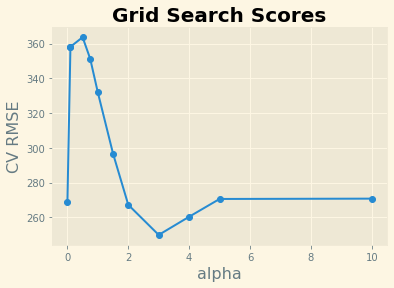

In [8]:
# Define the alphas to look at. This is done iteratively and honed in on. Shown here is the last step
alpha = [.001, 0.1, .1, .5, .75, 1, 1.5, 2, 3, 4, 5, 10]
# Placeholder 2nd parameter as my code was written for 2 (does not affect the analysis)
max_iter = [10000000]
# Create our parameter grid
param_grid = { 'alpha': alpha
              ,'max_iter': max_iter
             }
# Define our GridSearch with a Lasso regression using k=5 for cross-validation and RMSE for scoring
grid_search = GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 0, scoring = 'neg_root_mean_squared_error').fit(X, ysp)

# Call our defined procedure with the correct parameters
plot_grid_search(grid_search.cv_results_, alpha, max_iter, 'alpha', 'Max Iter')

In [9]:
# Define our optimized lasso regression and fit to X and y
lasso_opt = Lasso(alpha = 3)
lasso_opt.fit(X, ysp)
# Predict y with X
y_pred = lasso_opt.predict(X)
# Return R2
print('R2:', metrics.r2_score(ysp, y_pred))
# Return RMSE
print('RMSE:', sqrt(metrics.mean_squared_error(ysp, y_pred)))

R2: 0.5273188473305627
RMSE: 173.0146122266165


Text(0, 0.5, 'Residual')

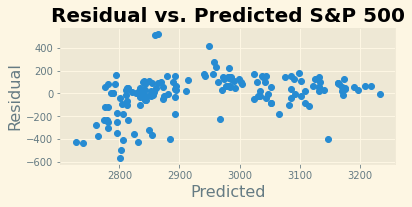

In [10]:
# Create a residual vs predicted plot to ensure we do not discern a clear pattern
pred_val = lasso_opt.predict(X)
true_val = ysp
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(pred_val, residual)
ax.set_title("Residual vs. Predicted S&P 500", fontsize=20, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Residual', fontsize=16)

In [11]:
# Return lasso coefficients
    # Put into proper data format
coefficients = pd.DataFrame(pd.concat([pd.DataFrame(col),pd.DataFrame(
    np.transpose(lasso_opt.coef_))], axis = 1))
coefficients = coefficients.values
coefficients = pd.DataFrame(coefficients, columns = ['Dimension', 'Coefficient'])

    # Exclude coefficients equal to zero
coef_not_zero = coefficients[coefficients['Coefficient']!=0]

    # Sort and print coefficients
coef_not_zero = coef_not_zero.sort_values(by = ['Coefficient']).reset_index()
print(coef_not_zero[['Dimension', 'Coefficient']])


           Dimension Coefficient
0      joy_intensity -539.976361
1    anger_intensity  528.976088
2     fear_intensity  569.898685
3  valence_intensity  993.323645


In [12]:
# Return lasso intercept
print(lasso_opt.intercept_)

2321.380319838462


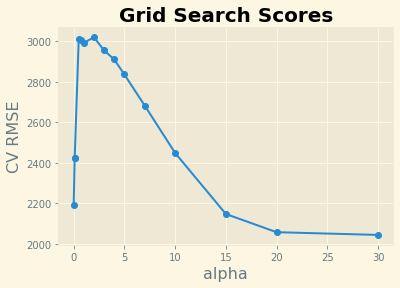

In [13]:
# Calling Method
alpha = [.001, 0.1, .1, .5, .75, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30]
max_iter = [10000000]
param_grid = { 'alpha': alpha
              ,'max_iter': max_iter
              
             }
grid_search = GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 0, scoring = 'neg_root_mean_squared_error').fit(X, ydw)

plot_grid_search(grid_search.cv_results_, alpha, max_iter, 'alpha', 'Max Iter')

In [14]:
# Define our optimized lasso regression and fit to X and y
lasso_opt = Lasso(alpha = 20)
lasso_opt.fit(X, ydw)
# Predict y with X
y_pred = lasso_opt.predict(X)
# Return R2
print('R2:', metrics.r2_score(ydw, y_pred))
# Return RMSE
print('RMSE:', sqrt(metrics.mean_squared_error(ydw, y_pred)))

R2: 0.569416722350609
RMSE: 1412.7184955717203


Text(0, 0.5, 'Residual')

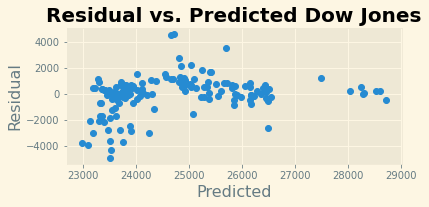

In [15]:
# Create a residual vs predicted plot to ensure we do not discern a clear pattern
pred_val = lasso_opt.predict(X)
true_val = ydw
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(pred_val, residual)
ax.set_title("Residual vs. Predicted Dow Jones", fontsize=20, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Residual', fontsize=16)

In [16]:
#Put into proper data format
coefficients = pd.DataFrame(pd.concat([pd.DataFrame(col),pd.DataFrame(
    np.transpose(lasso_opt.coef_))], axis = 1))
coefficients = coefficients.values
coefficients = pd.DataFrame(coefficients, columns = ['Dimension', 'Coefficient'])

#Exclude coefficients equal to zero
coef_not_zero = coefficients[coefficients['Coefficient']!=0]

#Sort and print coefficients
coef_not_zero = coef_not_zero.sort_values(by = ['Coefficient']).reset_index()
print(coef_not_zero[['Dimension', 'Coefficient']])

           Dimension  Coefficient
0      joy_intensity -3627.555869
1    anger_intensity  4323.279694
2     fear_intensity  7267.310394
3  valence_intensity  8472.610104


In [17]:
# Return Intercept
print(lasso_opt.intercept_)

18383.07003069902


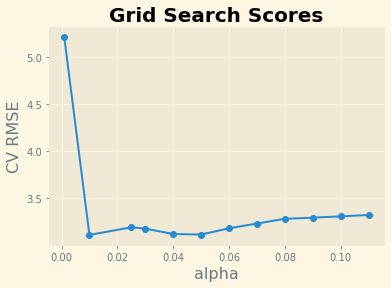

In [23]:
# Calling Method
alpha = [.001, .01, .025, .03, .04, .05, .06, .07, .08, .09, .1, .11]
max_iter = [10000000]
param_grid = { 'alpha': alpha
              ,'max_iter': max_iter
              
             }
grid_search = GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 0, scoring = 'neg_root_mean_squared_error').fit(X, yur)

plot_grid_search(grid_search.cv_results_, alpha, max_iter, 'alpha', 'Max Iter')

In [19]:
# Define our optimized lasso regression and fit to X and y
lasso_opt = Lasso(alpha = 0.05)
lasso_opt.fit(X, yur)
# Predict y with X
y_pred = lasso_opt.predict(X)
# Return R2
print('R2:', metrics.r2_score(yur, y_pred))
# Return RMSE
print('RMSE:', sqrt(metrics.mean_squared_error(yur, y_pred)))

R2: 0.5765397818017745
RMSE: 2.5714020330377405


Text(0, 0.5, 'Residual')

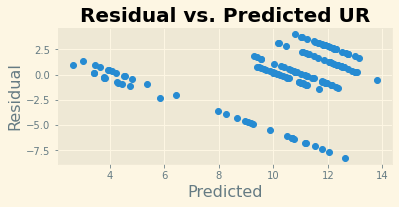

In [20]:
# Create a residual vs predicted plot to ensure we do not discern a clear pattern
    # In this case we do
pred_val = lasso_opt.predict(X)
true_val = yur
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(pred_val, residual)
ax.set_title("Residual vs. Predicted UR", fontsize=20, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Residual', fontsize=16)

In [21]:
#Put into proper data format
coefficients = pd.DataFrame(pd.concat([pd.DataFrame(col),pd.DataFrame(
    np.transpose(lasso_opt.coef_))], axis = 1))
coefficients = coefficients.values
coefficients = pd.DataFrame(coefficients, columns = ['Dimension', 'Coefficient'])

#Exclude coefficients equal to zero
coef_not_zero = coefficients[coefficients['Coefficient']!=0]

#Sort and print coefficients
coef_not_zero = coef_not_zero.sort_values(by = ['Coefficient']).reset_index()
print(coef_not_zero[['Dimension', 'Coefficient']])

                  Dimension Coefficient
0  emotion_category_sadness    4.031663
1      emotion_category_joy      9.4833


In [22]:
# Return Intercept
print(lasso_opt.intercept_)

2.133973347291679
